In [1]:
import numpy as np
import re
import nltk
from datasets import load_dataset
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from collections import Counter

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt

In [2]:
# nltk.download('all')

# Part 0. Dataset Preparation

In [3]:
# loading the dataset from the library
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset ['train']
validation_dataset = dataset ['validation']
test_dataset = dataset ['test']

In [4]:
# check the sizes of each dataset
train_size = len(train_dataset)
validation_size = len(validation_dataset)
test_size = len(test_dataset)

print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {validation_size}")
print(f"Test dataset size: {test_size}")

Training dataset size: 8530
Validation dataset size: 1066
Test dataset size: 1066


In [5]:
# view an example from each dataset
print("Train Dataset")
print(train_dataset.features)
print(train_dataset[0]) 

print("Test Dataset")
print(test_dataset.features)
print(test_dataset[0]) 

print("Validation Dataset")
print(validation_dataset.features)
print(validation_dataset[0])

Train Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}
Test Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .', 'label': 1}
Validation Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .', 'label': 1}


# Part 1. Preparing Word Embeddings

### Preprocessing

In [6]:
def preprocessing(text):

    # remove any other special characters but keep the general ones for potential sentiment usage
    text = re.sub(r'[^a-zA-Z0-9\'\!\?\.]', ' ', text)
    
    # replace multiple spaces with one space only
    text = re.sub(r'\s+', ' ', text)

    # remove leading and trailing whitespace to avoid unnecessary inconsistency 
    text = text.strip()

    return text

# apply the preprocessing function to the 'text' column of each dataset
train_dataset = train_dataset.map(lambda x: {'text': preprocessing(x['text'])})
validation_dataset = validation_dataset.map(lambda x: {'text': preprocessing(x['text'])})
test_dataset = test_dataset.map(lambda x: {'text': preprocessing(x['text'])})

# an example of the processed text
print("Train Dataset Example:")
print(train_dataset[0])

Train Dataset Example:
{'text': "the rock is destined to be the 21st century's new conan and that he's going to make a splash even greater than arnold schwarzenegger jean claud van damme or steven segal .", 'label': 1}


In [7]:
# tokenization
# empty list to store the resulting sentences
tokenized_sentences = []

for text in train_dataset['text']:
    # Tokenize the text and append the tokenized sentence to the list
    tokenized_sentences.append(word_tokenize(text))

### (a) Size of vocabulary in training data

In [8]:
# empty set for storing unique words
original_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the words set
        original_vocab.add(word)

print(f"(a) The size of vocabulary formed in the training data is {len(original_vocab)}")

(a) The size of vocabulary formed in the training data is 16683


### (b) Number of OOV in the training data

In [9]:
# adjust the parameters for word2vec
vector_size = 100 # Dimensionality of the word vectors
window = 3 # Maximum distance between the current and predicted word within a sentence
min_count = 2 # Ignores all words with total frequency lower than this
workers = 4 # CPU cores
sg = 1 # 1 for skip-gram, 0 for CBOW
epochs = 5 

# train the word2vec model
word2vec_model = Word2Vec(
    sentences = tokenized_sentences, 
    vector_size = vector_size, 
    window = window, 
    min_count = min_count, 
    workers = workers,
    epochs = epochs)

# variable to store model's vocab list 
word2vec_vocab = set(word2vec_model.wv.key_to_index)

# Calculate OOV words by comparing the original vocab and Word2Vec vocab
oov_words = original_vocab - word2vec_vocab

print(f"(b) Number of OOV words in the training data is {len(oov_words)} when the minimum threshold for each word is {min_count}")

(b) Number of OOV words in the training data is 7866 when the minimum threshold for each word is 2


### (c) Mitigating OOV

In [10]:
# define the UNK token
UNK_TOKEN = 'UNK'

# process each sentence in the tokenized_sentences list
for i, sentence in enumerate(tokenized_sentences):
    # empty list to store the current processed sentence
    processed_sentence = []

    for word in sentence:
        if word in word2vec_vocab:
            # if the current word is in the model's vocab, keep it as it is
            processed_sentence.append(word)  
        else:
            # otherwise, replace the word with UNK
            processed_sentence.append(UNK_TOKEN)  

    # update the sentence in the original tokenized_sentences list
    tokenized_sentences[i] = processed_sentence

# Create a vector for UNK using the mean of all other vectors
word2vec_model.wv[UNK_TOKEN] = np.mean(word2vec_model.wv.vectors, axis=0)

In [11]:
# example output after OOV handling
print(tokenized_sentences[0])

['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', 'conan', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'jean', 'UNK', 'van', 'damme', 'or', 'steven', 'UNK', '.']


### Embedding matrix creation

In [12]:
# empty set for storing unique words
final_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the final_vocab set
        final_vocab.add(word)

# create the dictionary that maps each word in final_vocab to a unique index
word_to_index = {word: i for i, word in enumerate(final_vocab)}

# get the size of word vectors from the Word2Vec model setting
embedding_dim = word2vec_model.vector_size 

# initialize embedding matrix with number of vocab and embedding dimension
embedding_matrix = np.zeros((len(final_vocab), embedding_dim))

# fill the embedding matrix with the corresponding word vectors
for word, i in word_to_index.items():
    embedding_matrix[i] = word2vec_model.wv[word]

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (8818, 100)


In [13]:
# example: first word from the dictionary and its word vector from embedding matrix
first_word = list(word_to_index.keys())[list(word_to_index.values()).index(0)]
first_vector = embedding_matrix[0]
print(f"Word: {first_word}, Vector: {first_vector}")

Word: no, Vector: [-0.52151471  1.0045675   0.12462048  0.15908162  0.0503222  -1.0098002
  0.53689295  1.43787432 -0.63894999 -0.32059124 -0.53901273 -0.96449935
  0.16934809  0.17926529  0.22953063 -0.39521602  0.48907897 -0.50607157
 -0.3087588  -1.74376726  0.18155649  0.0555489   0.67103964 -0.53821546
 -0.2167761   0.19467603 -0.35587817 -0.2412416  -0.67259806  0.47483835
  0.88702148 -0.19828263 -0.01480343 -0.86407495 -0.03122517  0.62254333
  0.29970866  0.04507557 -0.09869605 -0.61929345 -0.02213295 -0.8415516
 -0.29647717  0.41078499  0.88766855 -0.26827329 -0.33776304 -0.02820083
  0.10982857  0.18399563  0.12966718 -0.7443518  -0.07751903 -0.35377401
 -0.09806787  0.06568612  0.43365738 -0.13401522 -0.20849028  0.2837548
  0.38562256  0.18252099  0.4282718   0.08926893 -0.61847186  1.05401611
  0.4776352   0.75871241 -0.80977029  0.7125392  -0.07480943  0.59839368
  0.79504055  0.25613907  0.67417461  0.65223241 -0.03458844  0.23211341
 -0.14381015 -0.01419801 -0.66908109

# Part 2. Model Training & Evaluation - RNN

In [28]:
# add '<UNK>' and '<PAD>' to the vocabulary
final_vocab.add('<UNK>')
final_vocab.add('<PAD>')

# create the dictionary that maps each word in final_vocab to a unique index
word_to_index = {word: i for i, word in enumerate(final_vocab)}

if '<UNK>' not in word_to_index:
    word_to_index['<UNK>'] = len(word_to_index)
if '<PAD>' not in word_to_index:
    word_to_index['<PAD>'] = len(word_to_index)

embedding_dim = word2vec_model.vector_size 

# initialize embedding matrix with number of vocab and embedding dimension
embedding_matrix = np.zeros((len(word_to_index), embedding_dim))

# fill the embedding matrix with the corresponding word vectors
for word, i in word_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # random initialization for unknown words and special tokens
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

# convert word to indices 
def words_to_indices(sentence, word_to_index):
    return [word_to_index.get(word, word_to_index['<UNK>']) for word in sentence.split()]

train_X = [words_to_indices(sentence, word_to_index) for sentence in train_dataset['text']]
train_y = train_dataset['label']
val_X = [words_to_indices(sentence, word_to_index) for sentence in validation_dataset['text']]
val_y = validation_dataset['label']
test_X = [words_to_indices(sentence, word_to_index) for sentence in test_dataset['text']]
test_y = test_dataset['label']

def create_dataloader(X, y, batch_size=16, shuffle=True):
    X_tensor = [torch.tensor(seq, dtype=torch.long) for seq in X]
    X_padded = pad_sequence(X_tensor, batch_first=True, padding_value=word_to_index['<PAD>'])
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_padded, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = create_dataloader(train_X, train_y, shuffle=True)
val_dataloader = create_dataloader(val_X, val_y, shuffle=False)
test_dataloader = create_dataloader(test_X, test_y, shuffle=False)

# convert embedding_matrix to tensor
embedding_matrix = torch.FloatTensor(embedding_matrix)


Shape of embedding matrix: (8820, 100)


In [29]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, embedding_matrix, 
                 freeze_embeddings=True, aggregation_method='max_pooling',dropout_rate=0.2):
        super().__init__()
        
        # convert numpy embedding matrix to tensor
        embedding_tensor = torch.FloatTensor(embedding_matrix)
        
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, padding_idx=pad_idx, 
                                                      freeze=freeze_embeddings)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        # attention layer for attention aggregation method
        self.attention = nn.Linear(hidden_dim, 1)
        
        self.aggregation_method = aggregation_method
        
    def forward(self, text):
        #embedded = self.embedding(text)
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        
        if self.aggregation_method == 'last_hidden':
            # use the last hidden state
            sentence_repr = hidden.squeeze(0)
        elif self.aggregation_method == 'last_output':
            # use the last output
            sentence_repr = output[:, -1, :]
        elif self.aggregation_method == 'mean_pooling':
            # average all outputs
            sentence_repr = torch.mean(output, dim=1)
        elif self.aggregation_method == 'max_pooling':
            # max pooling over the sequence
            sentence_repr, _ = torch.max(output, dim=1)
        elif self.aggregation_method == 'attention':
            # Attention mechanism
            attention_weights = F.softmax(self.attention(output), dim=1)
            sentence_repr = torch.sum(attention_weights * output, dim=1)
        sentence_repr = self.dropout(sentence_repr)
        return self.fc(sentence_repr)

In [30]:
# shall we use bidirectional rnn?

# import torch.nn.functional as F

# class SentimentRNN(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, embedding_matrix, 
#                  freeze_embeddings=True, aggregation_method='max_pooling', dropout_rate=0.2):
#         super().__init__()
        
#         # convert numpy embedding matrix to tensor
#         embedding_tensor = torch.FloatTensor(embedding_matrix)
        
#         self.embedding = nn.Embedding.from_pretrained(embedding_tensor, padding_idx=pad_idx, 
#                                                       freeze=freeze_embeddings)
        
#         self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 because of bidirectional
#         self.dropout = nn.Dropout(dropout_rate)
#         # attention layer for attention aggregation method
#         self.attention = nn.Linear(hidden_dim * 2, 1)  # *2 because of bidirectional
        
#         self.aggregation_method = aggregation_method
        
#     def forward(self, text):
#         embedded = self.dropout(self.embedding(text))
#         output, hidden = self.rnn(embedded)
        
#         if self.aggregation_method == 'last_hidden':
#             # concatenate the last hidden state from both directions
#             sentence_repr = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
#         elif self.aggregation_method == 'last_output':
#             # concatenate the last output from both directions
#             sentence_repr = torch.cat((output[:, -1, :hidden.size(2)], 
#                                        output[:, 0, hidden.size(2):]), dim=1)
#         elif self.aggregation_method == 'mean_pooling':
#             # average all outputs
#             sentence_repr = torch.mean(output, dim=1)
#         elif self.aggregation_method == 'max_pooling':
#             # max pooling over the sequence
#             sentence_repr, _ = torch.max(output, dim=1)
#         elif self.aggregation_method == 'attention':
#             # Attention mechanism
#             attention_weights = F.softmax(self.attention(output), dim=1)
#             sentence_repr = torch.sum(attention_weights * output, dim=1)
        
#         sentence_repr = self.dropout(sentence_repr)
#         return self.fc(sentence_repr)

In [31]:
# max pooling used for sentence aggregation
vocab_size = len(word_to_index)
embedding_dim = embedding_matrix.shape[1]  # match word2vec vector size
hidden_dim = 256
output_dim = 2  
pad_idx = word_to_index['<PAD>'] if '<PAD>' in word_to_index else 0  

model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, 
                     embedding_matrix, freeze_embeddings=True, 
                     aggregation_method='max_pooling')
print(model)

# verify embedding layer
print(f"Embedding layer shape: {model.embedding.weight.shape}")
print(f"Embedding layer requires gradient: {model.embedding.weight.requires_grad}")


SentimentRNN(
  (embedding): Embedding(8820, 100, padding_idx=5060)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (attention): Linear(in_features=256, out_features=1, bias=True)
)
Embedding layer shape: torch.Size([8820, 100])
Embedding layer requires gradient: False


In [36]:
def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience):
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch in train_dataloader:
            inputs, label = batch
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += calculate_accuracy(label, predicted)
        
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        # validation
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, label = batch
                
                outputs = model(inputs)
                loss = criterion(outputs, label)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += calculate_accuracy(label, predicted)
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
    
    return best_val_loss, val_acc

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true.numpy(), y_pred.numpy())

def hyperparameter_tuning(model, train_dataloader, val_dataloader):
    param_grid = {
        'lr': [0.01, 0.001, 0.0001],
        'weight_decay': [1e-5],
        'batch_size': [16, 32, 64],
        'num_epochs': [50],
        'patience': [5]
    }
    
    grid = ParameterGrid(param_grid)
    best_params = None
    best_val_loss = float('inf')
    best_val_acc = 0
    
    for params in grid:
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        
        val_loss, val_acc = train_and_evaluate(
            model, train_dataloader, val_dataloader, criterion, optimizer, 
            params['num_epochs'], params['patience']
        )
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_params = params
    
    return best_params, best_val_loss, best_val_acc

best_params, best_val_loss, best_val_acc = hyperparameter_tuning(model, train_dataloader, val_dataloader)
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# train using the best parameters
model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

final_val_loss, final_val_acc = train_and_evaluate(
    model, train_dataloader, val_dataloader, criterion, optimizer, 
    best_params['num_epochs'], best_params['patience']
)

print(f"Final validation loss: {final_val_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

Best parameters: {'batch_size': 16, 'lr': 0.0001, 'num_epochs': 50, 'patience': 5, 'weight_decay': 1e-05}
Best validation loss: 0.5865
Best validation accuracy: 0.6817
Final validation loss: 0.6005
Final validation accuracy: 0.6825


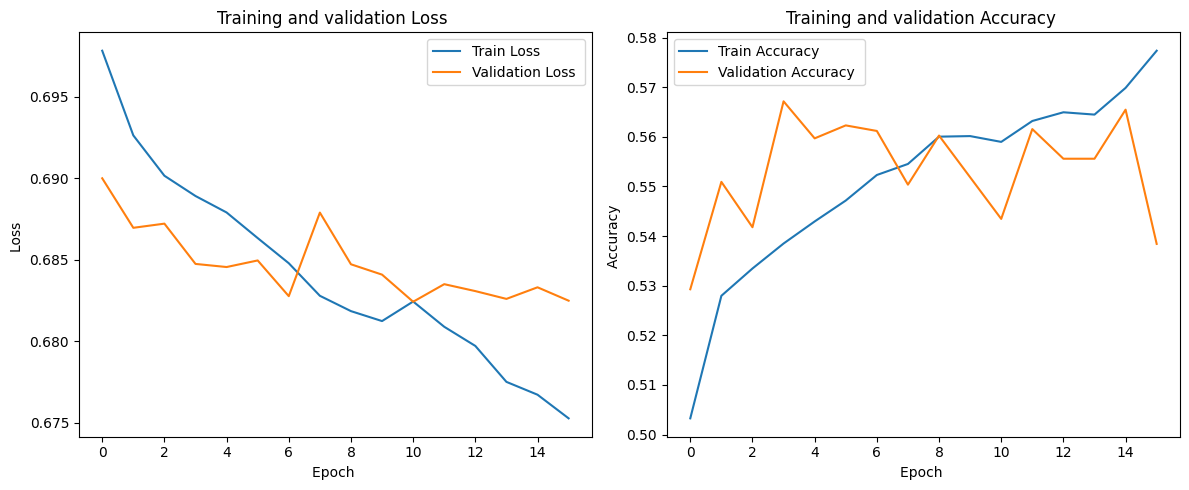

In [37]:
plt.figure(figsize=(12, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss ')
plt.plot(val_losses, label='Validation Loss ')
plt.title('Training and validation Loss ')
plt.xlabel('Epoch ')
plt.ylabel('Loss ')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy ')
plt.plot(val_accs, label='Validation Accuracy ')
plt.title('Training and validation Accuracy ')
plt.xlabel('Epoch ')
plt.ylabel('Accuracy ')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate on test dataset

In [43]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()  
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():  
    for inputs, label in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, label)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

test_loss /= len(test_dataloader)
test_acc = accuracy_score(all_labels, all_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.5696
Test Accuracy: 0.7026


## c) Sentence aggregation : max pooling is the best (test using best parameters from previous section)

In [45]:
# test for word representation aggregation ([ 'mean_pooling', 'max_pooling'])
def train_model(aggregation_method, num_epochs=50, learning_rate=0.0001):
    model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, 
                         embedding_matrix, freeze_embeddings=True, 
                         aggregation_method=aggregation_method)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch in train_dataloader:
            inputs, labels = batch
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += calculate_accuracy(labels, predicted)
        
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += calculate_accuracy(labels, predicted)
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_model_{aggregation_method}.pth')
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement == patience:
            print("Early stopping triggered")
            break
    
    return train_losses, train_accs, val_losses, val_accs

aggregation_methods = ['mean_pooling', 'max_pooling','last_hidden','last_output','attention']
results = {}

for method in aggregation_methods:
    print(f"\nTraining model with {method} aggregation method")
    train_losses, train_accs, val_losses, val_accs = train_model(method)
    results[method] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }


Training model with mean_pooling aggregation method
Epoch 1/50
Train Loss: 0.6864, Train Acc: 0.5441
Val Loss: 0.6818, Val Acc: 0.5623
Epoch 2/50
Train Loss: 0.6746, Train Acc: 0.5794
Val Loss: 0.6779, Val Acc: 0.5724
Epoch 3/50
Train Loss: 0.6700, Train Acc: 0.5975
Val Loss: 0.6826, Val Acc: 0.5623
Epoch 4/50
Train Loss: 0.6686, Train Acc: 0.5939
Val Loss: 0.6990, Val Acc: 0.5558
Epoch 5/50
Train Loss: 0.6647, Train Acc: 0.5983
Val Loss: 0.6776, Val Acc: 0.5660
Epoch 6/50
Train Loss: 0.6650, Train Acc: 0.5976
Val Loss: 0.6759, Val Acc: 0.5735
Epoch 7/50
Train Loss: 0.6636, Train Acc: 0.6022
Val Loss: 0.6732, Val Acc: 0.5754
Epoch 8/50
Train Loss: 0.6617, Train Acc: 0.6050
Val Loss: 0.6752, Val Acc: 0.5780
Epoch 9/50
Train Loss: 0.6617, Train Acc: 0.6031
Val Loss: 0.6784, Val Acc: 0.5707
Epoch 10/50
Train Loss: 0.6594, Train Acc: 0.6045
Val Loss: 0.6797, Val Acc: 0.5754
Epoch 11/50
Train Loss: 0.6597, Train Acc: 0.6083
Val Loss: 0.6784, Val Acc: 0.5763
Epoch 12/50
Train Loss: 0.6579, 

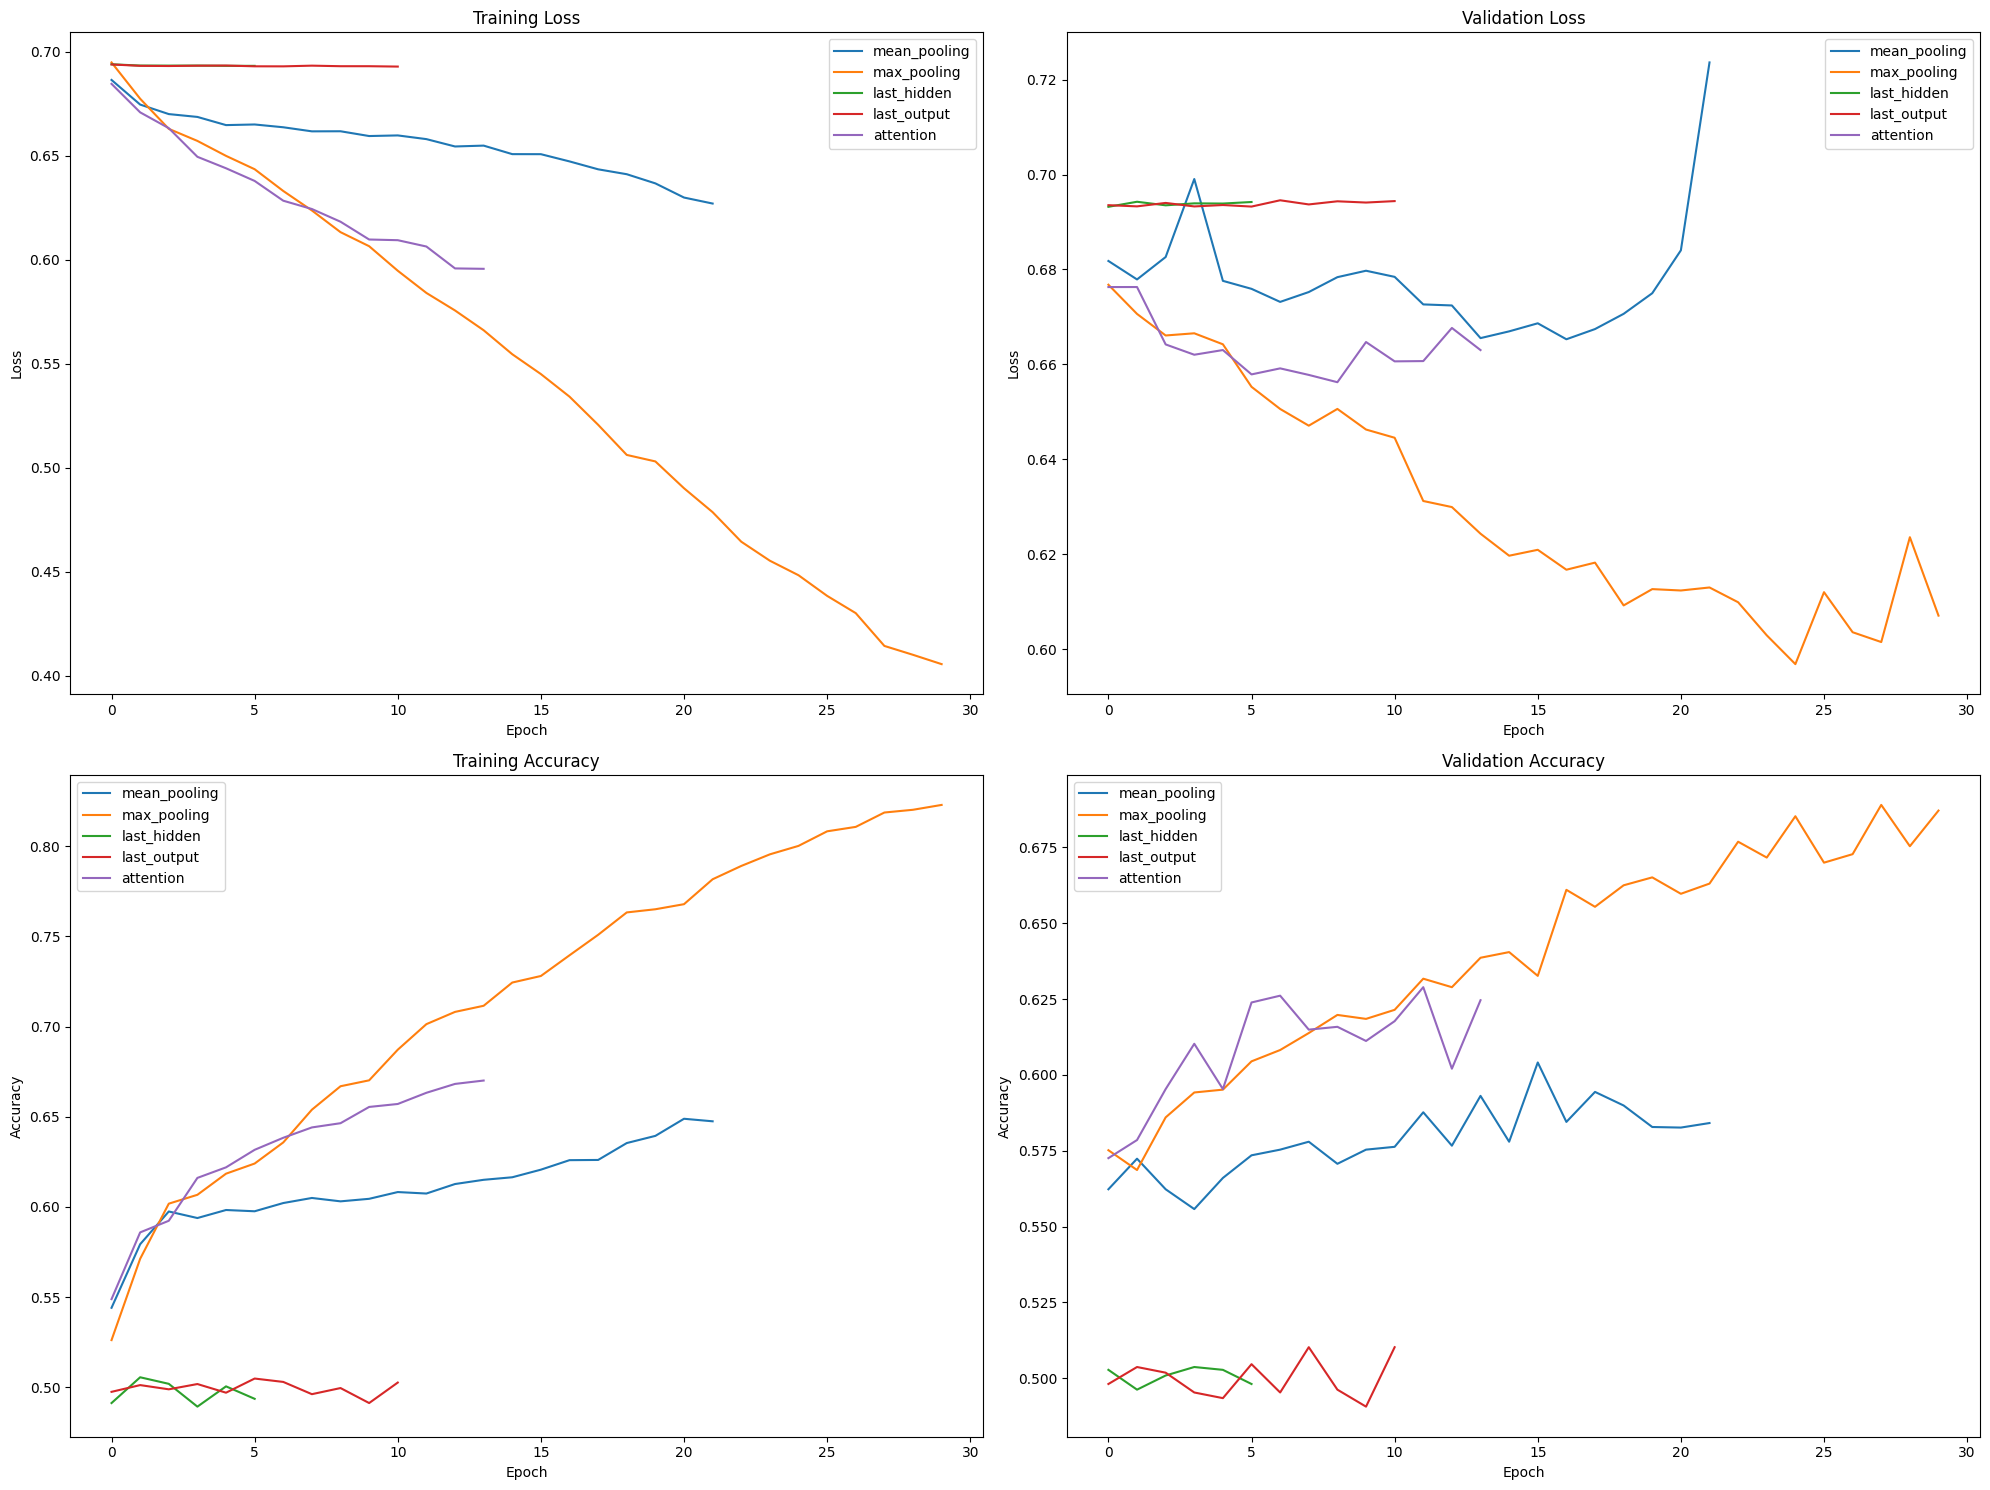

In [46]:
# plotting

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

for method in aggregation_methods:
    ax1.plot(results[method]['train_losses'], label=method)
    ax2.plot(results[method]['val_losses'], label=method)
    ax3.plot(results[method]['train_accs'], label=method)
    ax4.plot(results[method]['val_accs'], label=method)

ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

ax3.set_title('Training Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

ax4.set_title('Validation Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend()

plt.tight_layout()
plt.savefig('aggregation_methods_comparison.png')
plt.show()